In [1]:
from environments.pickplace_environment import SimplifyPickEnvWithoutLangReward,SimplifyPickOrPlaceEnvWithoutLangReward
import numpy as np
import matplotlib.pyplot as plt
from environments.utils import mouse_demo
from tasks.task import PutBlockInBowl
from agents.LLMRL import LLMSAC,GuideSAC
import cv2

pybullet build time: May 20 2022 19:44:17
2023-10-27 11:29:42.870506: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-27 11:29:43.129948: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 11:29:44.267947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from PIL import Image
import torch
from reward.detector import VILD

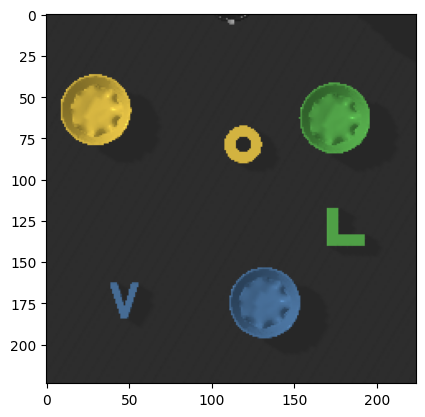

In [3]:
# image_path = "reward/tmp/color.png"
image_path = "writting/img/letter.png"
image = Image.open(image_path)
plt.imshow(image)

In [4]:
vild = VILD()


Instructions for updating:
Use `tf.saved_model.load` instead.


2023-10-27 11:30:02.968688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-27 11:30:02.972770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-27 11:30:02.972870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

INFO:tensorflow:Restoring parameters from ./reward/image_path_v2/variables/variables


2023-10-27 11:30:03.764095: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


Time taken: 0.402s
Building text embeddings...
Found a bowl with score: 0.30422682 with position: [58.36244201660156, 30.13572120666504]
Found a bowl with score: 0.30235532 with position: [175.38479614257812, 132.25689697265625]
Found a green Letter L with score: 0.30229968 with position: [63.70582580566406, 174.63555908203125]
Found a yellow Letter O with score: 0.2953614 with position: [79.22601318359375, 119.05255126953125]
Found a green Letter L with score: 0.28289646 with position: [129.26431274414062, 181.62188720703125]
Found a blue Letter V with score: 0.27970922 with position: [173.61517333984375, 47.03557205200195]
Found a bowl with score: 0.2687534 with position: [184.20101928710938, 157.42214965820312]
Found a green Letter L with score: 0.26522264 with position: [71.931884765625, 200.35968017578125]
Found a green Letter L with score: 0.24513943 with position: [177.66847229003906, 56.93518829345703]
Found 10 objects


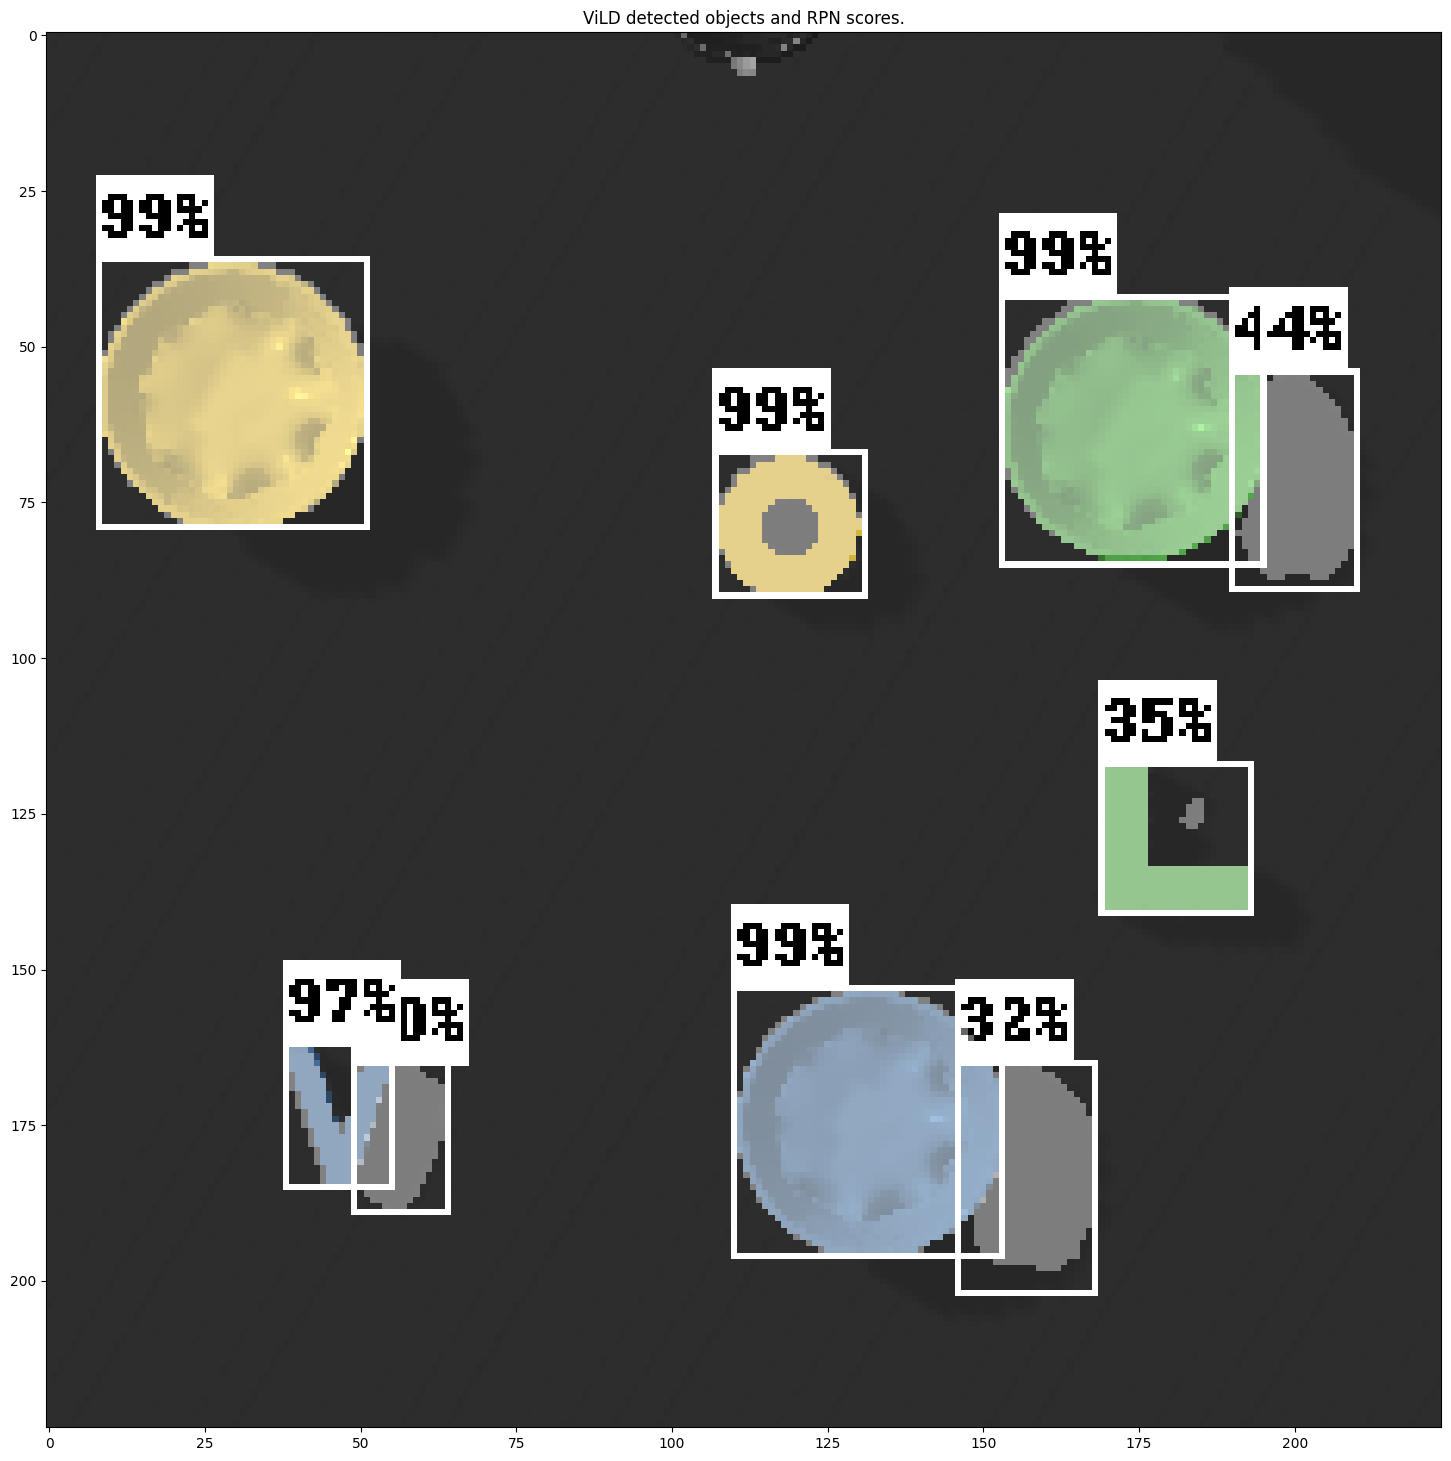

([('bowl',
   [58.36244201660156, 30.13572120666504],
   [36, 8, 79, 51],
   0.30422682),
  ('bowl',
   [175.38479614257812, 132.25689697265625],
   [153, 110, 196, 153],
   0.30235532),
  ('green Letter L',
   [63.70582580566406, 174.63555908203125],
   [42, 153, 85, 195],
   0.30229968),
  ('yellow Letter O',
   [79.22601318359375, 119.05255126953125],
   [67, 107, 90, 131],
   0.2953614),
  ('green Letter L',
   [129.26431274414062, 181.62188720703125],
   [117, 169, 141, 193],
   0.28289646),
  ('blue Letter V',
   [173.61517333984375, 47.03557205200195],
   [162, 38, 185, 55],
   0.27970922),
  ('bowl',
   [184.20101928710938, 157.42214965820312],
   [165, 146, 202, 168],
   0.2687534),
  ('green Letter L',
   [71.931884765625, 200.35968017578125],
   [54, 190, 89, 210],
   0.26522264),
  ('green Letter L',
   [177.66847229003906, 56.93518829345703],
   [165, 49, 189, 64],
   0.24513943)],
 array([[[45, 45, 45],
         [45, 45, 45],
         [44, 44, 44],
         ...,
         

In [7]:
vild.vild_detect(image_path,["blocks","bowl","yellow Letter O","blue Letter V", "green Letter L"],verbose= True)